In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import time
import seaborn as sns
import time

dataset_path = '/kaggle/input/dataset/final_dataset'


data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(dataset_path, transform=data_transforms)


train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_test_set = random_split(dataset, [train_size, val_size + test_size])
val_set, test_set = random_split(val_test_set, [val_size, test_size])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [11]:
from timm import create_model

models_dict = {
    "ResNet18": models.resnet18(pretrained=True),
    "EfficientNet": models.efficientnet_b0(pretrained=True),
    "DenseNet121": models.densenet121(pretrained=True),
    "Xception": create_model("xception", pretrained=True, num_classes=2),
    "MobileNetV2": models.mobilenet_v2(pretrained=True),
}
model_input_sizes = {
    "ResNet18": (224, 224),
    "EfficientNet": (224, 224),
    "DenseNet121": (224, 224),
    "Xception": (299, 299),
    "MobileNetV2": (224, 224),
}


In [12]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()



def train_model(model_name, model, train_loader, val_loader, epochs=10, patience=1):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_val_acc = float('inf')
    best_val_loss = float('inf')
    patience_counter = 0
    best_epoch = 0

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "latency": []}

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        epoch_start = time.time()

        for inputs, labels in tqdm(train_loader, desc=f"Training {model_name}, Epoch {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_end = time.time()
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        epoch_latency = epoch_end - epoch_start

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Validating {model_name}, Epoch {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / val_total

        # Update training history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["latency"].append(epoch_latency)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Latency: {epoch_latency:.2f}s")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(),f"best_model_{model_name}.pth")  # Save in Kaggle's writable directory
            best_epoch = epoch + 1
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs. Best epoch: {best_epoch}")
            break

    return model, history


# Prepare DataLoader for different input sizes
def get_data_loaders(input_size):
    data_transforms = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    # Implement your dataset preparation here
    return train_loader, val_loader


# Initialize results table and model histories
results_list = []
histories = {}

# Iterate over models
for model_name, model in models_dict.items():
    input_size = model_input_sizes[model_name]
    train_loader, val_loader = get_data_loaders(input_size)

    # Adjust the final layer for binary classification
    if hasattr(model, 'fc'):
        model.fc = nn.Linear(model.fc.in_features, 2)
    elif hasattr(model, 'classifier'):
        if isinstance(model.classifier, nn.Sequential):
            model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
        else:
            model.classifier = nn.Linear(model.classifier.in_features, 2)
    elif hasattr(model, 'head'):
        model.head = nn.Linear(model.head.in_features, 2)
    else:
        print(f"Model {model_name} does not have an adjustable classification head. Skipping.")
        continue

    print(f"Training {model_name}...")
    trained_model, history = train_model(model_name, model, train_loader, val_loader)
    histories[model_name] = history

    # Log results for comparison
    results_list.append({
        "Model": model_name,
        "Train Acc": max(history["train_acc"]),
        "Val Acc": max(history["val_acc"]),
        "Latency": sum(history["latency"]),
    })

# Convert results to DataFrame
results_table = pd.DataFrame(results_list)

# Save results
results_table.to_csv("model_comparison_results.csv", index=False)
print("Training completed. Results saved to `model_comparison_results.csv`.")


Training ResNet18...


Validating ResNet18, Epoch 1: 100%|██████████| 141/141 [00:16<00:00,  8.66it/s]


Epoch 1/10 - Train Loss: 0.1649, Train Acc: 0.9325, Val Loss: 0.2707, Val Acc: 0.9087, Latency: 100.73s


Validating ResNet18, Epoch 2: 100%|██████████| 141/141 [00:13<00:00, 10.35it/s]


Epoch 2/10 - Train Loss: 0.0245, Train Acc: 0.9924, Val Loss: 0.0345, Val Acc: 0.9862, Latency: 88.66s


Validating ResNet18, Epoch 3: 100%|██████████| 141/141 [00:13<00:00, 10.24it/s]


Epoch 3/10 - Train Loss: 0.0123, Train Acc: 0.9962, Val Loss: 0.0025, Val Acc: 0.9991, Latency: 90.48s


Validating ResNet18, Epoch 4: 100%|██████████| 141/141 [00:13<00:00, 10.57it/s]


Epoch 4/10 - Train Loss: 0.0101, Train Acc: 0.9967, Val Loss: 0.0098, Val Acc: 0.9967, Latency: 89.40s
Early stopping triggered after 4 epochs. Best epoch: 3
Training EfficientNet...


Validating EfficientNet, Epoch 1: 100%|██████████| 141/141 [00:14<00:00,  9.51it/s]


Epoch 1/10 - Train Loss: 0.0619, Train Acc: 0.9779, Val Loss: 0.0008, Val Acc: 0.9996, Latency: 126.20s


Validating EfficientNet, Epoch 2: 100%|██████████| 141/141 [00:15<00:00,  9.01it/s]


Epoch 2/10 - Train Loss: 0.0122, Train Acc: 0.9959, Val Loss: 0.0029, Val Acc: 1.0000, Latency: 126.09s
Early stopping triggered after 2 epochs. Best epoch: 1
Training DenseNet121...


Validating DenseNet121, Epoch 1: 100%|██████████| 141/141 [00:19<00:00,  7.25it/s]


Epoch 1/10 - Train Loss: 0.1486, Train Acc: 0.9385, Val Loss: 0.0232, Val Acc: 0.9936, Latency: 169.88s


Validating DenseNet121, Epoch 2: 100%|██████████| 141/141 [00:19<00:00,  7.27it/s]


Epoch 2/10 - Train Loss: 0.0454, Train Acc: 0.9841, Val Loss: 0.0197, Val Acc: 0.9933, Latency: 169.83s


Validating DenseNet121, Epoch 3: 100%|██████████| 141/141 [00:19<00:00,  7.42it/s]


Epoch 3/10 - Train Loss: 0.0260, Train Acc: 0.9907, Val Loss: 0.0034, Val Acc: 0.9993, Latency: 169.34s


Validating DenseNet121, Epoch 4: 100%|██████████| 141/141 [00:19<00:00,  7.41it/s]


Epoch 4/10 - Train Loss: 0.0247, Train Acc: 0.9917, Val Loss: 0.0035, Val Acc: 0.9987, Latency: 169.49s
Early stopping triggered after 4 epochs. Best epoch: 3
Training Xception...


Validating Xception, Epoch 1: 100%|██████████| 141/141 [00:22<00:00,  6.32it/s]


Epoch 1/10 - Train Loss: 0.0759, Train Acc: 0.9693, Val Loss: 0.0007, Val Acc: 1.0000, Latency: 242.56s


Validating Xception, Epoch 2: 100%|██████████| 141/141 [00:21<00:00,  6.44it/s]


Epoch 2/10 - Train Loss: 0.0141, Train Acc: 0.9953, Val Loss: 0.0001, Val Acc: 1.0000, Latency: 242.55s


Validating Xception, Epoch 3: 100%|██████████| 141/141 [00:22<00:00,  6.27it/s]


Epoch 3/10 - Train Loss: 0.0005, Train Acc: 0.9999, Val Loss: 0.0000, Val Acc: 1.0000, Latency: 243.78s


Validating Xception, Epoch 4: 100%|██████████| 141/141 [00:22<00:00,  6.30it/s]


Epoch 4/10 - Train Loss: 0.0095, Train Acc: 0.9976, Val Loss: 0.0000, Val Acc: 1.0000, Latency: 243.73s


Validating Xception, Epoch 5: 100%|██████████| 141/141 [00:22<00:00,  6.40it/s]


Epoch 5/10 - Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000, Latency: 243.48s


Validating Xception, Epoch 6: 100%|██████████| 141/141 [00:22<00:00,  6.20it/s]


Epoch 6/10 - Train Loss: 0.0132, Train Acc: 0.9959, Val Loss: 0.0002, Val Acc: 1.0000, Latency: 244.78s
Early stopping triggered after 6 epochs. Best epoch: 5
Training MobileNetV2...


Validating MobileNetV2, Epoch 1: 100%|██████████| 141/141 [00:14<00:00, 10.01it/s]


Epoch 1/10 - Train Loss: 0.0658, Train Acc: 0.9751, Val Loss: 0.0048, Val Acc: 0.9984, Latency: 109.68s


Validating MobileNetV2, Epoch 2: 100%|██████████| 141/141 [00:14<00:00, 10.05it/s]


Epoch 2/10 - Train Loss: 0.0208, Train Acc: 0.9932, Val Loss: 0.0028, Val Acc: 0.9996, Latency: 107.92s


Validating MobileNetV2, Epoch 3: 100%|██████████| 141/141 [00:13<00:00, 10.07it/s]


Epoch 3/10 - Train Loss: 0.0181, Train Acc: 0.9945, Val Loss: 0.0005, Val Acc: 1.0000, Latency: 108.77s


Validating MobileNetV2, Epoch 4: 100%|██████████| 141/141 [00:13<00:00, 10.09it/s]

Epoch 4/10 - Train Loss: 0.0021, Train Acc: 0.9994, Val Loss: 0.0010, Val Acc: 0.9998, Latency: 109.07s
Early stopping triggered after 4 epochs. Best epoch: 3
Training completed. Results saved to `model_comparison_results.csv`.


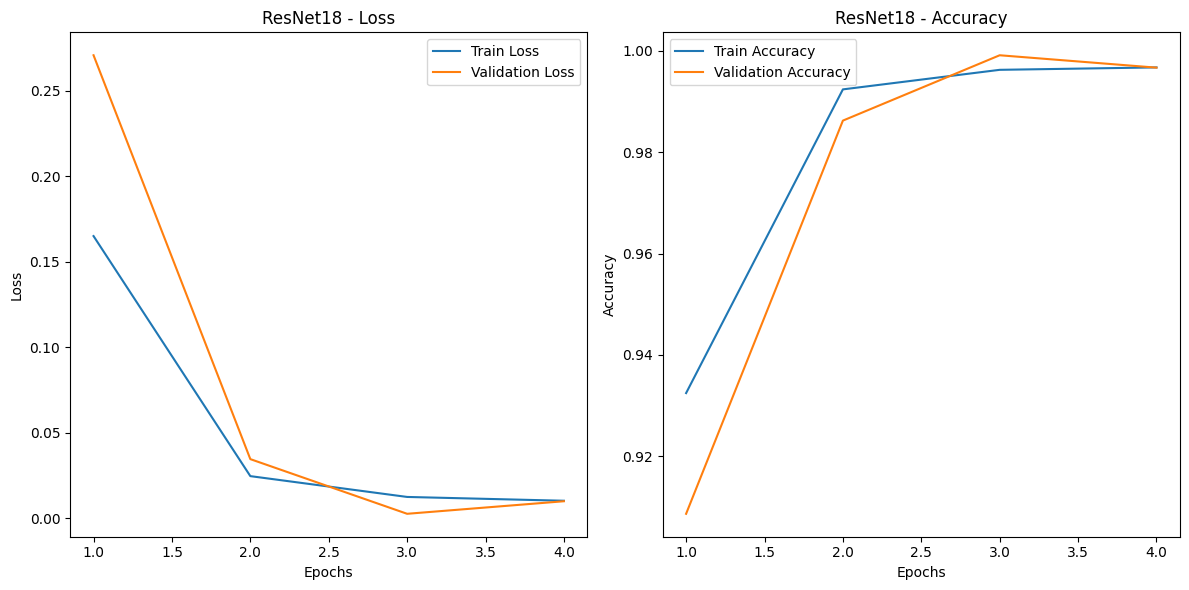

Evaluating ResNet18: 100%|██████████| 141/141 [00:20<00:00,  6.84it/s]


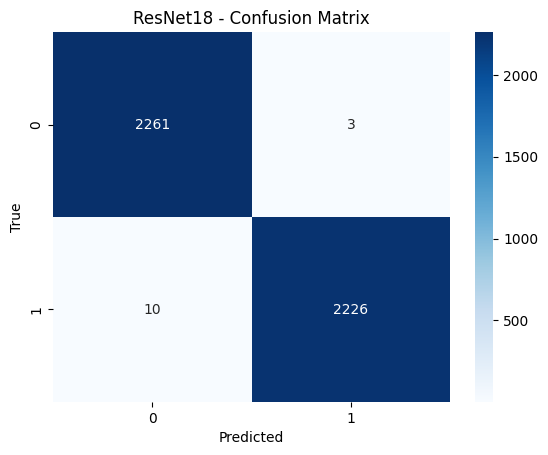

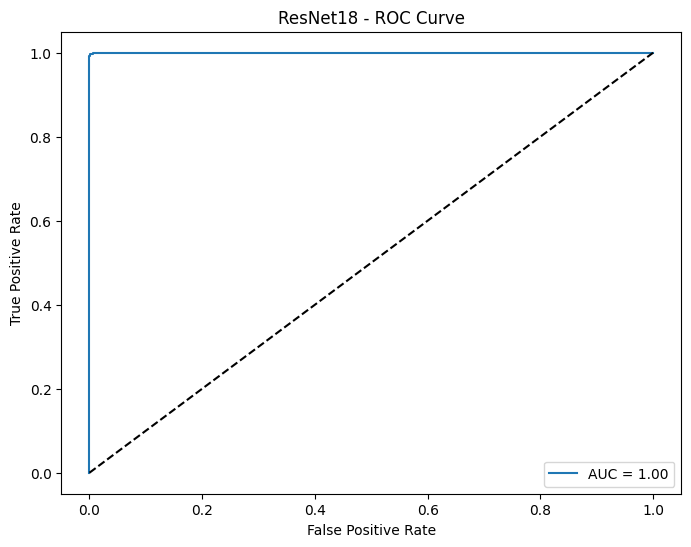

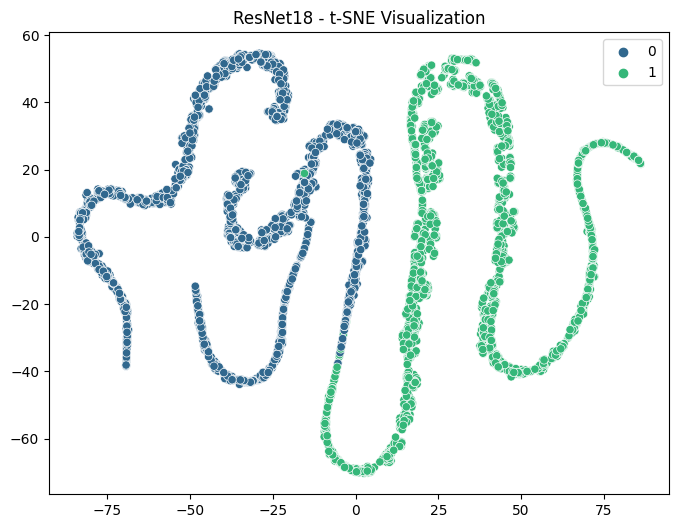

ResNet18 - Latency: 20.62s
ResNet18 - Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      2264
     Class 1       1.00      1.00      1.00      2236

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500



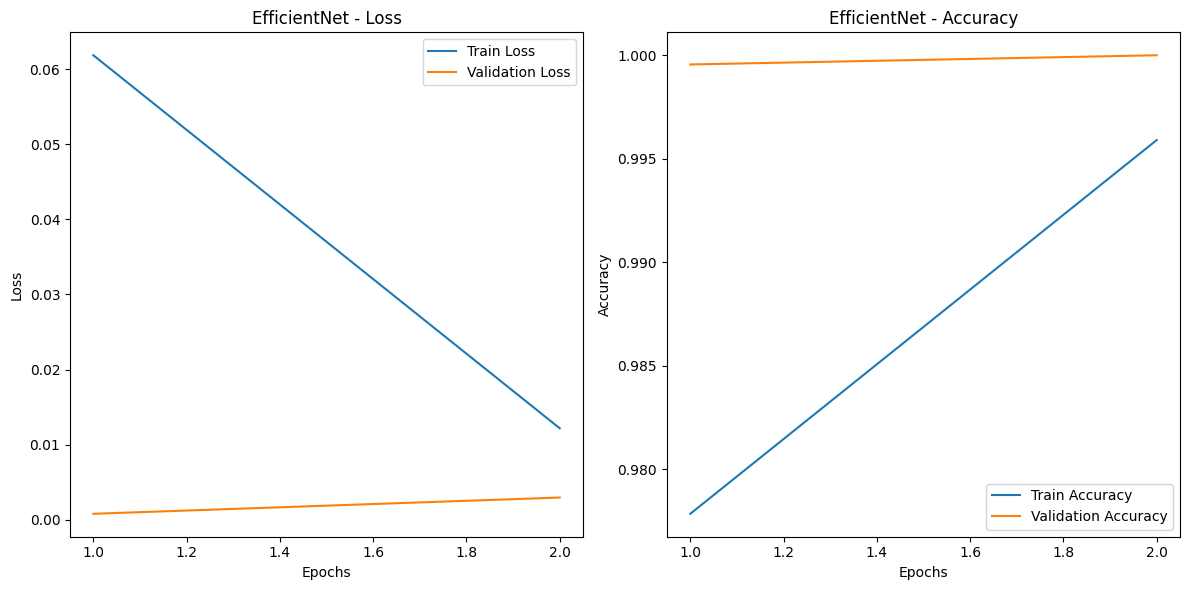

Evaluating EfficientNet: 100%|██████████| 141/141 [00:15<00:00,  9.11it/s]


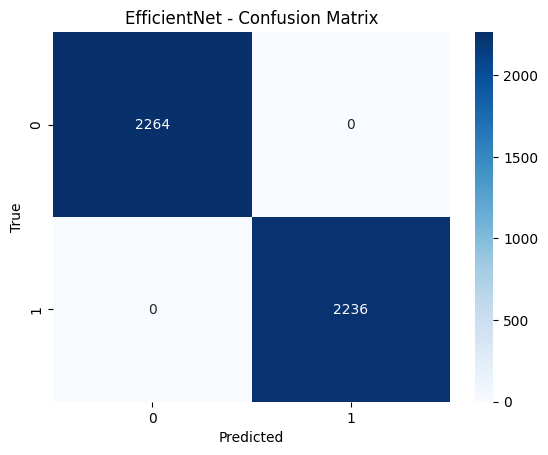

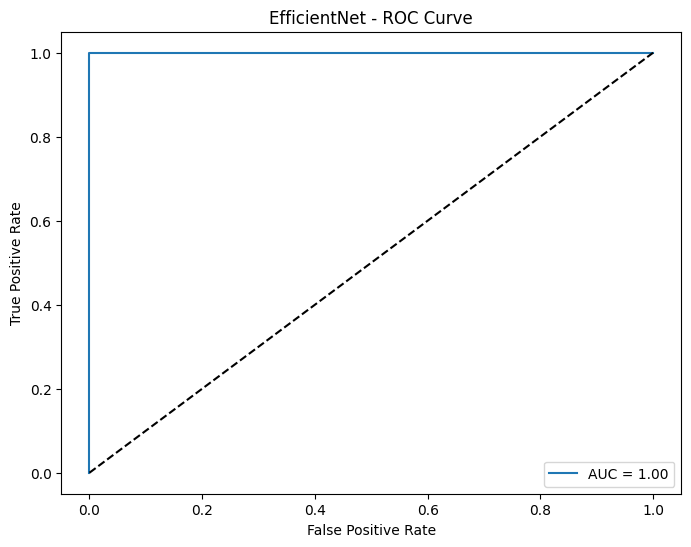

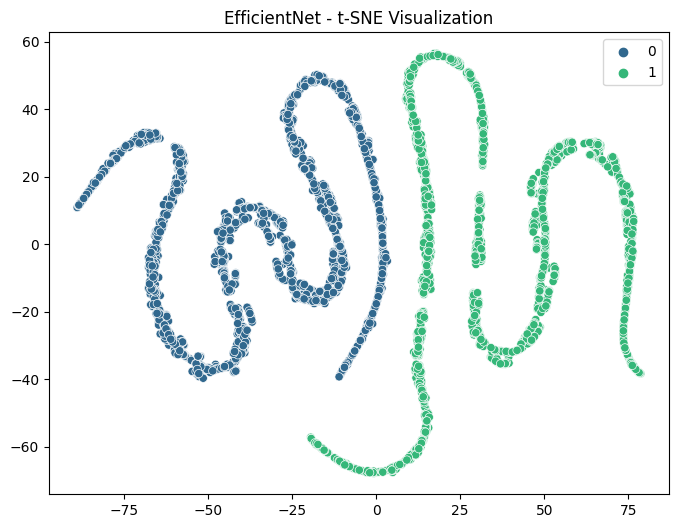

EfficientNet - Latency: 15.49s
EfficientNet - Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      2264
     Class 1       1.00      1.00      1.00      2236

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500



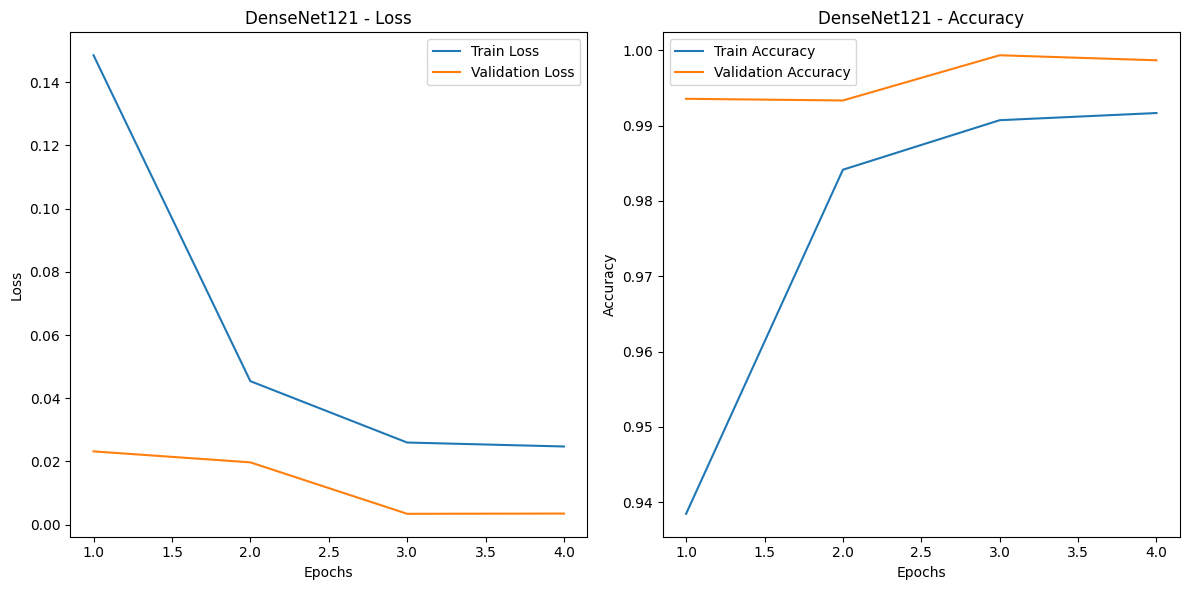

Evaluating DenseNet121: 100%|██████████| 141/141 [00:19<00:00,  7.14it/s]


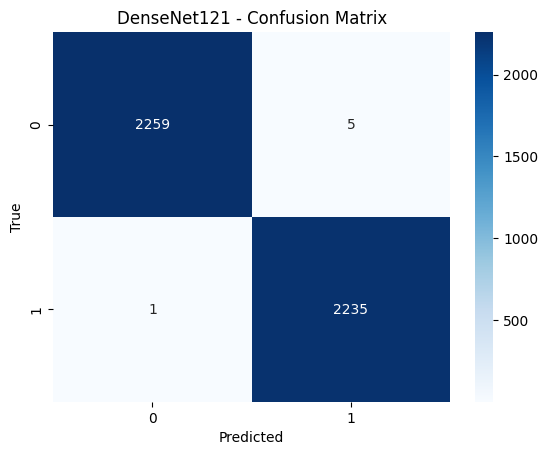

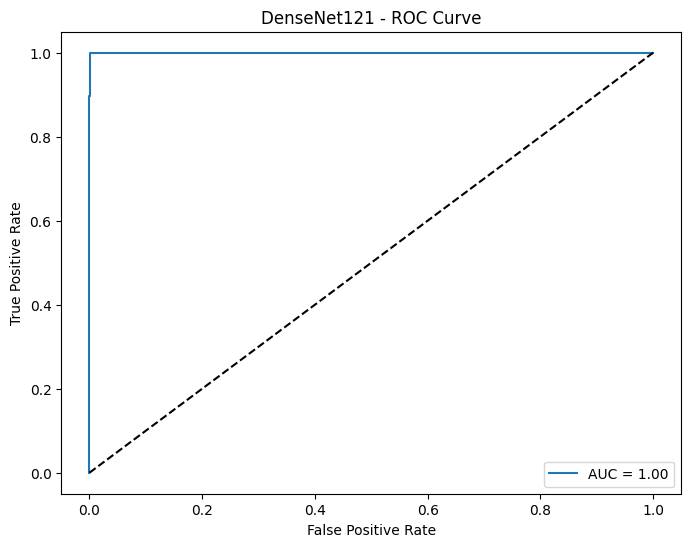

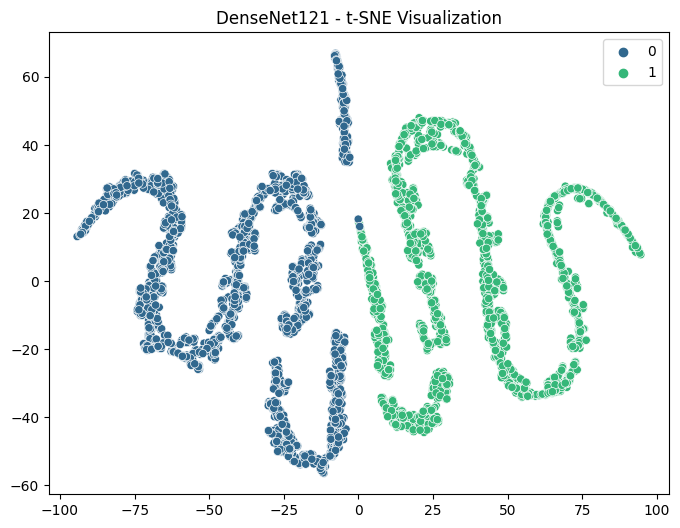

DenseNet121 - Latency: 19.74s
DenseNet121 - Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      2264
     Class 1       1.00      1.00      1.00      2236

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500



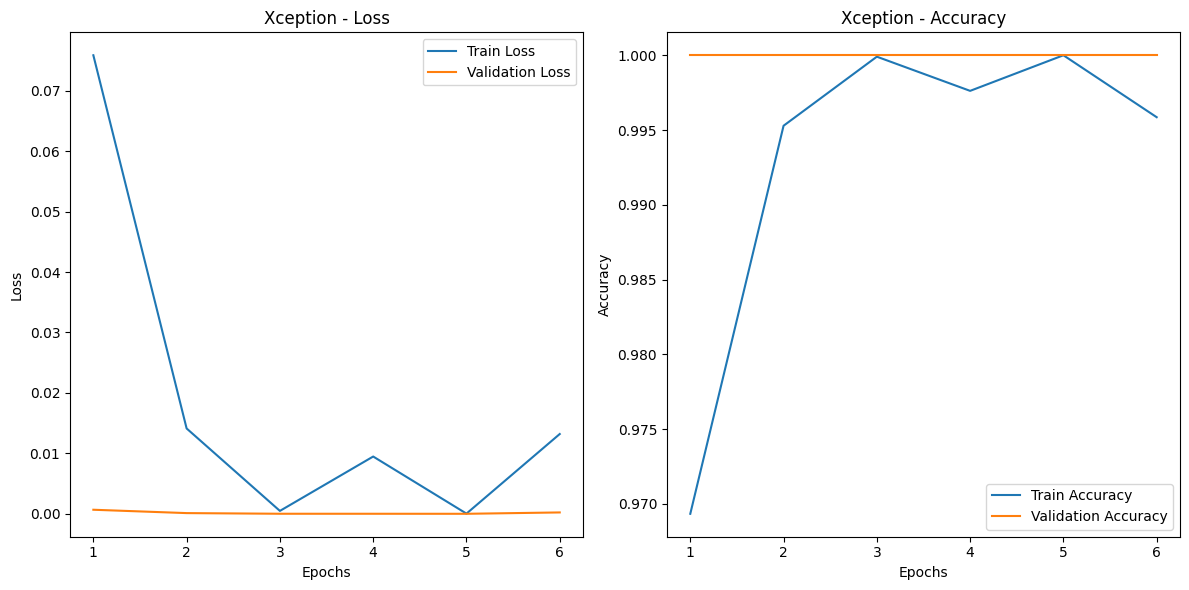

Evaluating Xception: 100%|██████████| 141/141 [00:22<00:00,  6.13it/s]


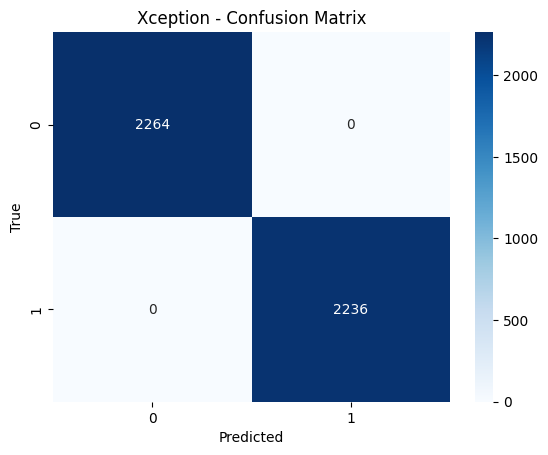

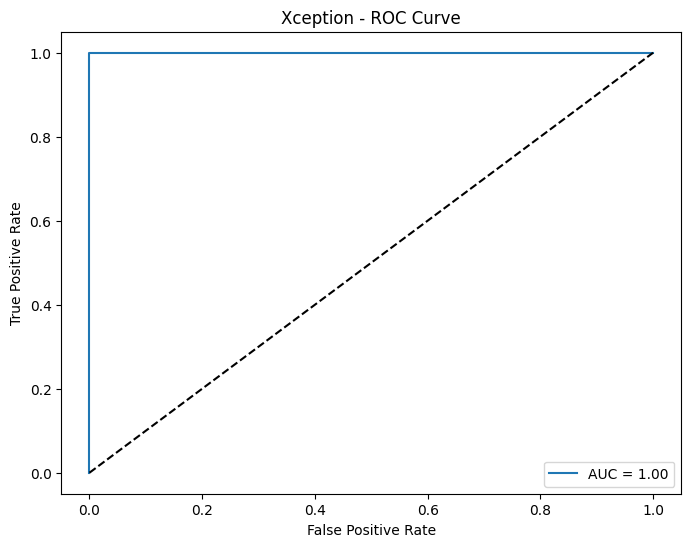

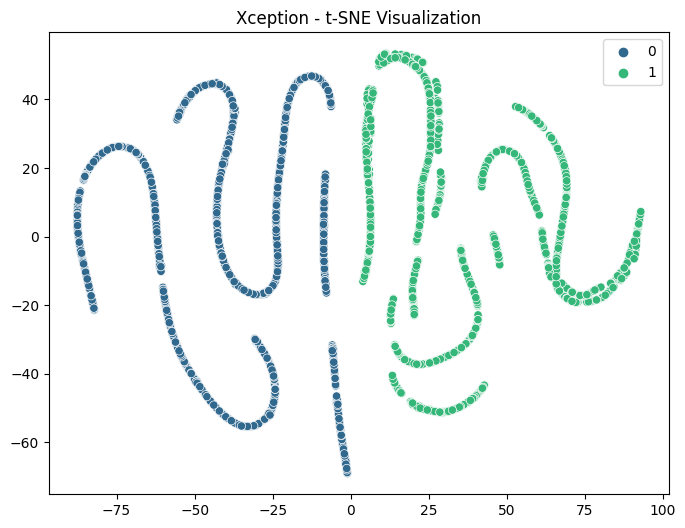

Xception - Latency: 22.99s
Xception - Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      2264
     Class 1       1.00      1.00      1.00      2236

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500



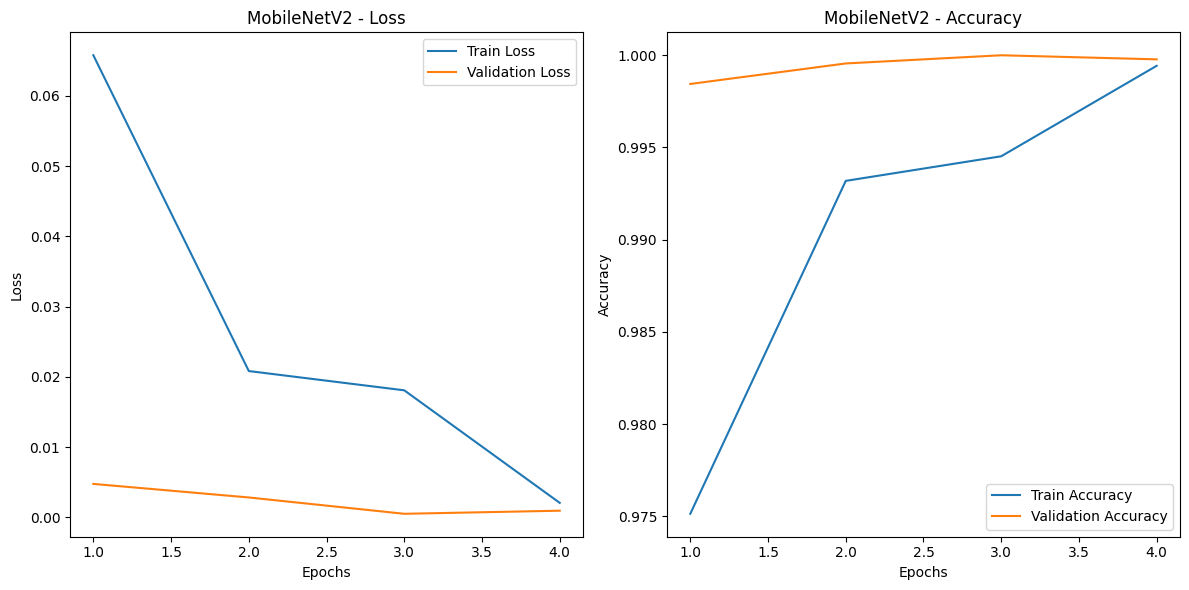

Evaluating MobileNetV2: 100%|██████████| 141/141 [00:15<00:00,  9.27it/s]


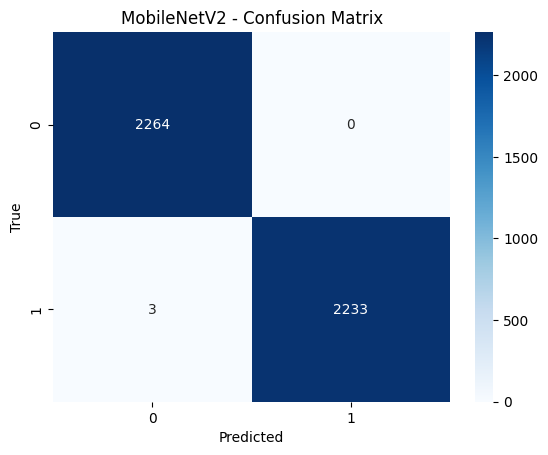

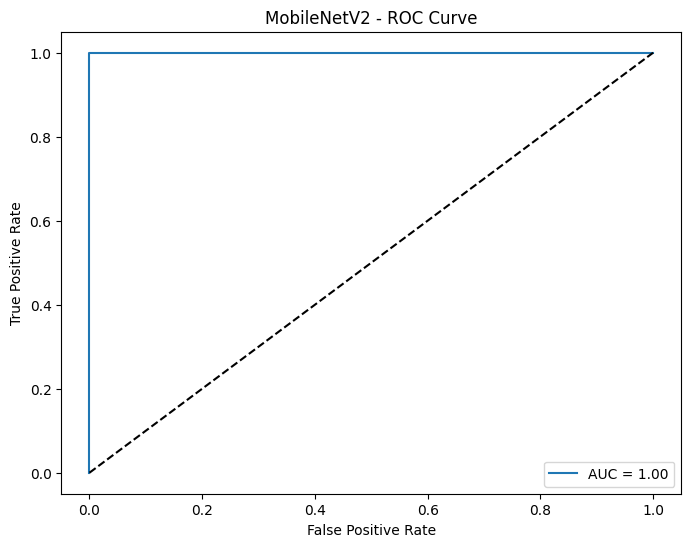

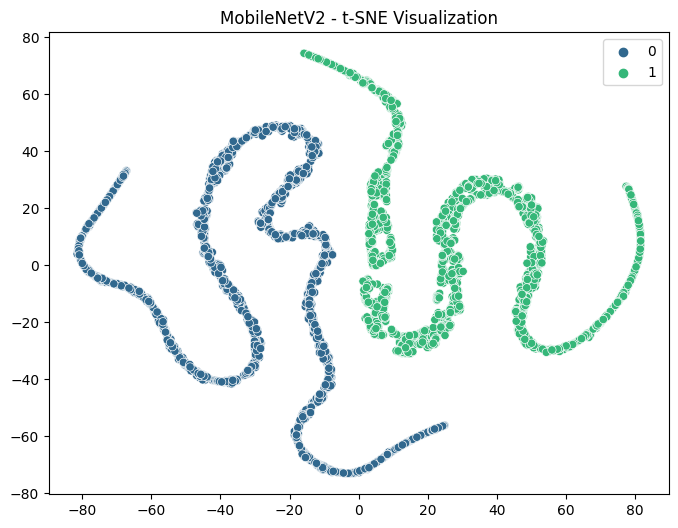

MobileNetV2 - Latency: 15.22s
MobileNetV2 - Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      2264
     Class 1       1.00      1.00      1.00      2236

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500



In [13]:
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

# Function to evaluate and display metrics for each model
def evaluate_and_display_models(models_dict, histories, test_loader):
    for model_name, model in models_dict.items():
        if model_name == "InceptionV3":
            print(f"Skipping {model_name}.")
            continue

        # Plot training history
        history = histories[model_name]
        plot_training_history(history, model_name)

        # Evaluate model
        classification_rep, latency = evaluate_model(model_name, model, test_loader)

        # Display latency
        print(f"{model_name} - Latency: {latency:.2f}s")
        print(f"{model_name} - Classification Report:\n{classification_rep}")

# Helper functions for plots and metrics
def plot_training_history(history, model_name):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model_name, model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    all_embeddings = []
    latency_start = time.time()

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            embeddings = outputs.detach().cpu().numpy()  # Extract logits for t-SNE
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)[:, 1]

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_embeddings.extend(embeddings)

    latency_end = time.time()
    latency = latency_end - latency_start

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{model_name} - ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # t-SNE Plot
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(np.array(all_embeddings))
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=all_labels, palette='viridis')
    plt.title(f'{model_name} - t-SNE Visualization')
    plt.show()

    # Classification Report
    classification_rep = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1'])

    return classification_rep, latency

# Run evaluation for all models
evaluate_and_display_models(models_dict, histories, test_loader)


In [10]:
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.datasets import ImageFolder
from PIL import Image
from torchvision import models
from timm import create_model
import os

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model weights for weighted averaging
model_weights = {
    "ResNet18": 0.2,
    "EfficientNet": 0.25,
    "DenseNet121": 0.25,
    "Xception": 0.15,
    "MobileNetV2": 0.15,
}

# Define model configurations
model_paths = {
    "ResNet18": "/kaggle/input/model/pytorch/default/1/best_model_ResNet18.pth",
    "EfficientNet": "/kaggle/input/models/pytorch/default/1/best_model_EfficientNet.pth",
    "DenseNet121": "/kaggle/input/model/pytorch/default/1/best_model_DenseNet121.pth",
    "Xception": "/kaggle/input/model/pytorch/default/1/best_model_Xception.pth",
    "MobileNetV2": "/kaggle/input/model/pytorch/default/1/best_model_MobileNetV2.pth",
}

models_dict = {
    "ResNet18": models.resnet18(pretrained=False),
    "EfficientNet": models.efficientnet_b0(pretrained=False),
    "DenseNet121": models.densenet121(pretrained=False),
    "Xception": create_model("xception", pretrained=False, num_classes=2),
    "MobileNetV2": models.mobilenet_v2(pretrained=False),
}

model_input_sizes = {
    "ResNet18": (224, 224),
    "EfficientNet": (224, 224),
    "DenseNet121": (224, 224),
    "Xception": (299, 299),
    "MobileNetV2": (224, 224),
}

# Adjust models for 2-class classification and load weights
for model_name, model in models_dict.items():
    if hasattr(model, 'fc'):
        model.fc = torch.nn.Linear(model.fc.in_features, 2)
    elif hasattr(model, 'classifier'):
        if isinstance(model.classifier, torch.nn.Sequential):
            model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, 2)
        else:
            model.classifier = torch.nn.Linear(model.classifier.in_features, 2)
    elif hasattr(model, 'head'):
        model.head = torch.nn.Linear(model.head.in_features, 2)

    model.load_state_dict(torch.load(model_paths[model_name], map_location=device))
    model.to(device)
    model.eval()

# Define dataset transformations
def get_transform(input_size):
    return Compose([
        Resize(input_size),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Load dataset
dataset_path = "/kaggle/input/dataset/final_dataset"  # Replace with your dataset path
dataset = ImageFolder(root=dataset_path)

# Select a random image from the dataset
random_index = torch.randint(0, len(dataset), (1,)).item()
image_path, label = dataset.samples[random_index]
image = Image.open(image_path).convert("RGB")
true_class = dataset.classes[label]

# Initialize variables for ensemble methods
class_votes = {cls: 0 for cls in dataset.classes}
prob_sum = torch.zeros(len(dataset.classes)).to(device)
weighted_prob_sum = torch.zeros(len(dataset.classes)).to(device)

# Perform predictions
individual_predictions = []

for model_name, model in models_dict.items():
    input_size = model_input_sizes[model_name]
    transform = get_transform(input_size)
    transformed_image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(transformed_image)
        probs = torch.softmax(outputs, dim=1)

        # Majority voting
        predicted_class_idx = torch.argmax(probs, dim=1).item()
        predicted_class_name = dataset.classes[predicted_class_idx]
        class_votes[predicted_class_name] += 1

        # Averaging
        prob_sum += probs.squeeze()

        # Weighted averaging
        weighted_prob_sum += model_weights[model_name] * probs.squeeze()

        # Collect individual model results
        confidence_score = probs[0, predicted_class_idx].item()
        individual_predictions.append(
            f"{model_name}: Predicted - {predicted_class_name} with Confidence - {confidence_score:.2f}"
        )

# Final Predictions
# Majority Voting
majority_vote_class = max(class_votes, key=class_votes.get)

# Averaging
average_probs = prob_sum / len(models_dict)
avg_predicted_class_idx = torch.argmax(average_probs).item()
avg_predicted_class_name = dataset.classes[avg_predicted_class_idx]
average_confidence = average_probs[avg_predicted_class_idx].item()

# Weighted Averaging
weighted_avg_probs = weighted_prob_sum / sum(model_weights.values())
weighted_avg_predicted_class_idx = torch.argmax(weighted_avg_probs).item()
weighted_avg_predicted_class_name = dataset.classes[weighted_avg_predicted_class_idx]
weighted_avg_confidence = weighted_avg_probs[weighted_avg_predicted_class_idx].item()

# Display Individual Model Predictions
print("Individual Model Predictions:")
for prediction in individual_predictions:
    print(prediction)

# Display Ensemble Results
print("\nEnsemble Results:")
print(f"Averaging: Predicted - {avg_predicted_class_name} with Confidence - {average_confidence:.2f}")
print(f"Weighted Averaging: Predicted - {weighted_avg_predicted_class_name} with Confidence - {weighted_avg_confidence:.2f}")
print(f"Majority Voting: Predicted - {majority_vote_class}")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
/tmp/ipykernel_23/1506747616.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytor

Individual Model Predictions:
ResNet18: Predicted - Normal with Confidence - 1.00
EfficientNet: Predicted - Normal with Confidence - 1.00
DenseNet121: Predicted - Normal with Confidence - 1.00
Xception: Predicted - Glaucoma with Confidence - 0.90
MobileNetV2: Predicted - Normal with Confidence - 1.00

Ensemble Results:
Averaging: Predicted - Normal with Confidence - 0.82
Weighted Averaging: Predicted - Normal with Confidence - 0.86
Majority Voting: Predicted - Normal


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

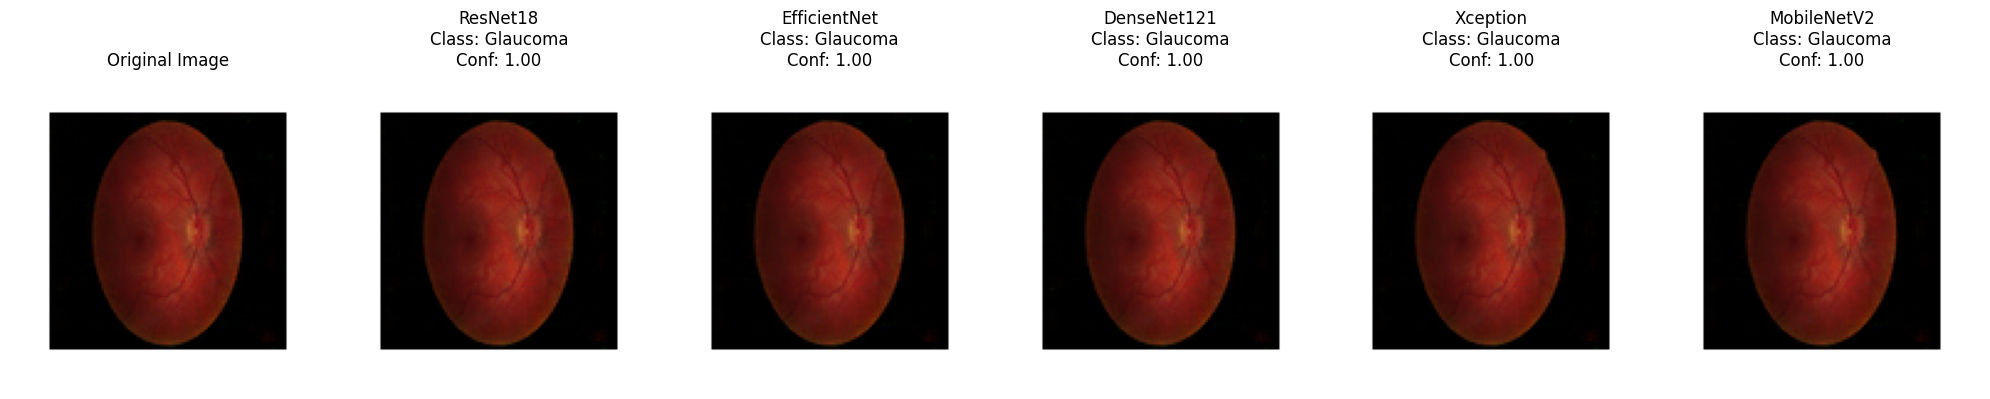

          Model True Class Predicted Class  Confidence Score
0      ResNet18   Glaucoma        Glaucoma          1.000000
1  EfficientNet   Glaucoma        Glaucoma          0.999999
2   DenseNet121   Glaucoma        Glaucoma          0.999995
3      Xception   Glaucoma        Glaucoma          0.999495
4   MobileNetV2   Glaucoma        Glaucoma          1.000000


In [15]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

# Define LIME utility function
def generate_lime(model, input_image, input_size):
    """
    Generate LIME explanation for the given model and input image.
    """
    def predict_fn(images):
        """
        Prediction function for LIME. Converts numpy images to tensors.
        """
        images = torch.stack([
            transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(input_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])(img) for img in images
        ]).to(device)
        with torch.no_grad():
            outputs = model(images)
        return torch.softmax(outputs, dim=1).cpu().numpy()

    explainer = lime_image.LimeImageExplainer()
    segmenter = SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2)
    explanation = explainer.explain_instance(
        np.array(input_image),
        predict_fn,
        top_labels=1,
        hide_color=0,
        segmentation_fn=segmenter,
    )
    return explanation

# Visualization function for LIME
def visualize_lime_results(image, models_dict, results, lime_explanations):
    """
    Visualize the LIME explanations for each model.
    """
    fig, axes = plt.subplots(1, len(models_dict) + 1, figsize=(20, 6))

    # Display the original image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Display LIME results for each model
    for i, (model_name, result) in enumerate(zip(models_dict.keys(), results)):
        if lime_explanations[i] is not None:
            lime_image, mask = lime_explanations[i].get_image_and_mask(
                lime_explanations[i].top_labels[0], positive_only=True, hide_rest=False, num_features=5, min_weight=0.0
            )
            axes[i + 1].imshow(lime_image)
        else:
            axes[i + 1].text(0.5, 0.5, "LIME Not Available",
                             horizontalalignment='center',
                             verticalalignment='center',
                             fontsize=10, color="red", transform=axes[i + 1].transAxes)
        axes[i + 1].set_title(
            f"{model_name}\nClass: {result['Predicted Class']}\nConf: {result['Confidence Score']:.2f}"
        )
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

# LIME application and visualization
results = []
lime_explanations = []

for model_name, model in models_dict.items():
    input_size = model_input_sizes[model_name]
    transform = get_transform(input_size)
    transformed_image = transform(image).unsqueeze(0).to(device)

    try:
        # Prediction
        with torch.no_grad():
            outputs = model(transformed_image)
            probs = torch.softmax(outputs, dim=1)
            confidence, predicted_class_idx = torch.max(probs, dim=1)
            predicted_class = dataset.classes[predicted_class_idx.item()]

        # LIME
        lime_explanation = generate_lime(model, image, input_size)
        lime_explanations.append(lime_explanation)

        # Append Results
        results.append({
            "Model": model_name,
            "True Class": true_class,
            "Predicted Class": predicted_class,
            "Confidence Score": confidence.item(),
        })
    except Exception as e:
        print(f"LIME failed for {model_name}: {e}")
        lime_explanations.append(None)

# Visualize Results
visualize_lime_results(image, models_dict, results, lime_explanations)

# Display Results Table
results_df = pd.DataFrame(results)
print(results_df)


In [1]:
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models
from timm import create_model

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model weights for weighted averaging
model_weights = {
    "ResNet18": 0.2,
    "EfficientNet": 0.25,
    "DenseNet121": 0.25,
    "Xception": 0.15,
    "MobileNetV2": 0.15,
}

# Define model configurations
models_dict = {
    "ResNet18": models.resnet18(pretrained=False),
    "EfficientNet": models.efficientnet_b0(pretrained=False),
    "DenseNet121": models.densenet121(pretrained=False),
    "Xception": create_model("xception", pretrained=False, num_classes=2),
    "MobileNetV2": models.mobilenet_v2(pretrained=False),
}

model_input_sizes = {
    "ResNet18": (224, 224),
    "EfficientNet": (224, 224),
    "DenseNet121": (224, 224),
    "Xception": (299, 299),
    "MobileNetV2": (224, 224),
}

# Load model paths
model_paths = {
    "ResNet18": "/kaggle/input/model/pytorch/default/1/best_model_ResNet18.pth",
    "EfficientNet": "/kaggle/input/models/pytorch/default/1/best_model_EfficientNet.pth",
    "DenseNet121": "/kaggle/input/model/pytorch/default/1/best_model_DenseNet121.pth",
    "Xception": "/kaggle/input/model/pytorch/default/1/best_model_Xception.pth",
    "MobileNetV2": "/kaggle/input/model/pytorch/default/1/best_model_MobileNetV2.pth",
}

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


/tmp/ipykernel_23/1103477735.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_paths[model_name], map_location=device))


Grad-CAM failed for ResNet18: get_target_layer() missing 1 required positional argument: 'model_name'
Grad-CAM failed for EfficientNet: get_target_layer() missing 1 required positional argument: 'model_name'
Grad-CAM failed for DenseNet121: get_target_layer() missing 1 required positional argument: 'model_name'
Grad-CAM failed for Xception: get_target_layer() missing 1 required positional argument: 'model_name'
Grad-CAM failed for MobileNetV2: get_target_layer() missing 1 required positional argument: 'model_name'


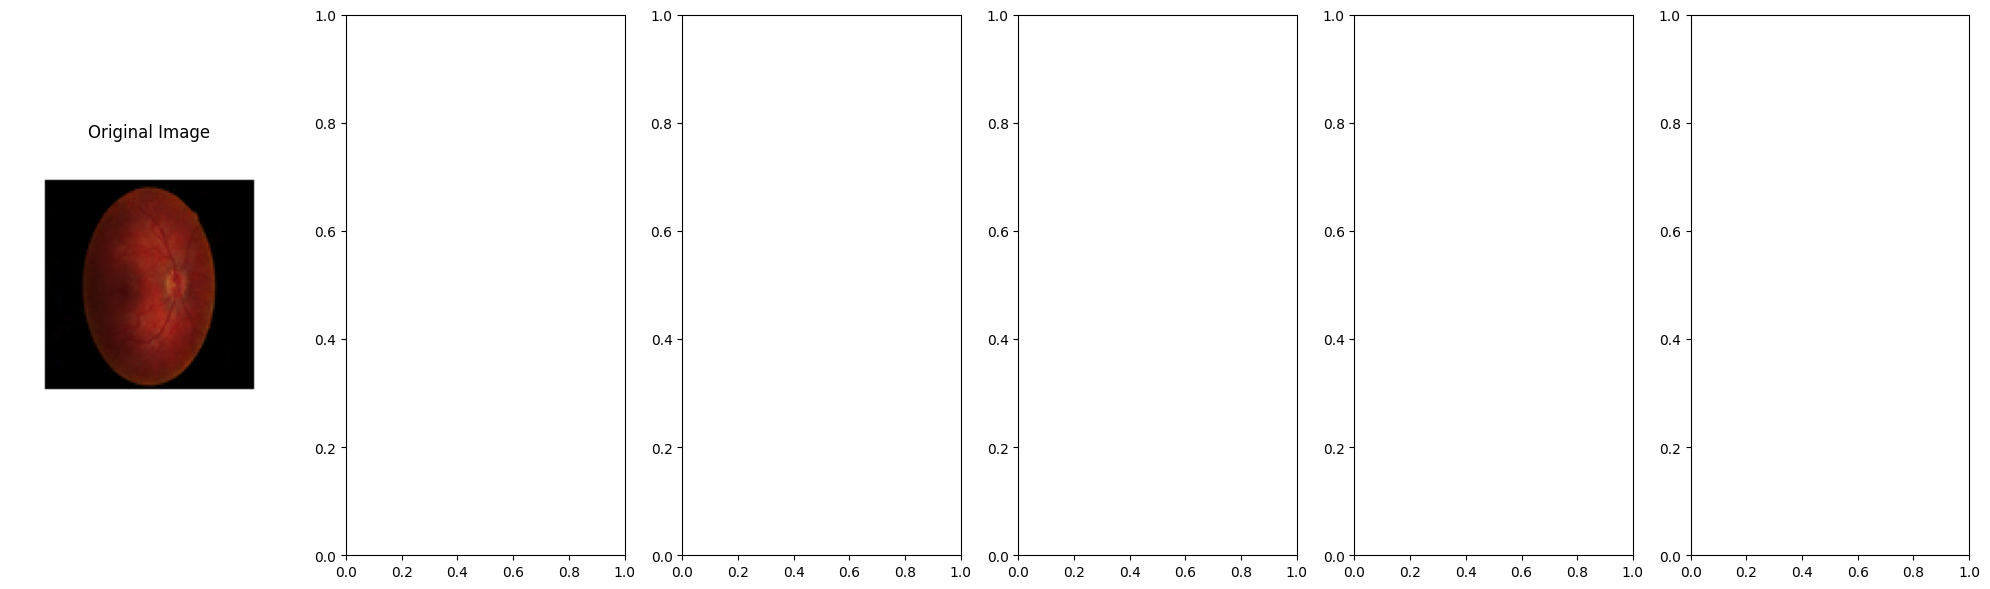

Empty DataFrame
Columns: []
Index: []


In [20]:

# Load models and adjust layers
for model_name, model in models_dict.items():
    if hasattr(model, 'fc'):
        model.fc = torch.nn.Linear(model.fc.in_features, 2)
    elif hasattr(model, 'classifier'):
        if isinstance(model.classifier, torch.nn.Sequential):
            model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, 2)
        else:
            model.classifier = torch.nn.Linear(model.classifier.in_features, 2)
    elif hasattr(model, 'head'):
        model.head = torch.nn.Linear(model.head.in_features, 2)

    # Load state dict
    model.load_state_dict(torch.load(model_paths[model_name], map_location=device))
    model.to(device)
    model.eval()

# Dataset transformations
def get_transform(input_size):
    return Compose([
        Resize(input_size),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Load dataset
dataset_path = "/kaggle/input/dataset/final_dataset"  # Replace with your dataset path
dataset = ImageFolder(root=dataset_path)

# Select a random image from the dataset
random_index = torch.randint(0, len(dataset), (1,)).item()
image_path, label = dataset.samples[random_index]
image = Image.open(image_path).convert("RGB")
true_class = dataset.classes[label]

# Grad-CAM utility functions
def generate_gradcam(model, transformed_image, target_layer):
    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    # Perform forward pass
    outputs = model(transformed_image)
    class_idx = torch.argmax(outputs, dim=1).item()

    # Perform backward pass
    model.zero_grad()
    outputs[0, class_idx].backward()

    # Generate Grad-CAM heatmap
    grad = gradients[0].cpu().data.numpy()
    act = activations[0].cpu().data.numpy()

    # Ensure compatible shapes by broadcasting
    weights = np.mean(grad, axis=(2, 3))
    cam = np.zeros(act.shape[2:], dtype=np.float32)
    for i, w in enumerate(weights[0]):
        cam += w * act[0, i]

    cam = np.maximum(cam, 0)
    cam = cam.max() - cam  # Reverse the values
    cam = cam / cam.max()  # Normalize to [0, 1]
    cam = (cam * 255).astype(np.uint8) 

    # Cleanup hooks
    handle_forward.remove()
    handle_backward.remove()

    return cam
def overlay_gradcam(image, cam, alpha=0.5):
    """
    Overlay Grad-CAM heatmap on the original image.
    """
    # Resize Grad-CAM to match the original image size
    cam_resized = cv2.resize(cam, (image.size[0], image.size[1]), interpolation=cv2.INTER_LINEAR)
    
    # Apply colormap to the heatmap
    cam_colored = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
    
    # Convert image to numpy array
    image_np = np.array(image)
    
    # Normalize image for consistent visualization
    if image_np.max() > 1:
        image_np = image_np / 255.0  # Scale to [0, 1]
    
    # Blend the original image and the Grad-CAM heatmap
    overlay = cv2.addWeighted(np.uint8(image_np * 255), 1 - alpha, cam_colored, alpha, 0)
    return overlay

# Grad-CAM application and visualization
results = []
gradcam_images = []

for model_name, model in models_dict.items():
    try:
        input_size = model_input_sizes[model_name]
        transform = get_transform(input_size)
        transformed_image = transform(image).unsqueeze(0).to(device)
        
        target_layer = get_target_layer(model)
        cam = generate_gradcam(model, transformed_image, target_layer)
        gradcam_overlay = overlay_gradcam(image, cam)

        # Prediction
        with torch.no_grad():
            outputs = model(transformed_image)
            probs = torch.softmax(outputs, dim=1)
            confidence, predicted_class_idx = torch.max(probs, dim=1)
            predicted_class = dataset.classes[predicted_class_idx.item()]

        gradcam_images.append((model_name, gradcam_overlay))
        results.append({
            "Model": model_name,
            "True Class": true_class,
            "Predicted Class": predicted_class,
            "Confidence Score": confidence.item(),
        })
    except Exception as e:
        print(f"Grad-CAM failed for {model_name}: {e}")

# Visualize Grad-CAM results
fig, axes = plt.subplots(1, len(models_dict) + 1, figsize=(20, 6))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

for i, (model_name, overlay) in enumerate(gradcam_images):
    axes[i + 1].imshow(overlay)
    axes[i + 1].set_title(f"{model_name}\nClass: {results[i]['Predicted Class']}\nConf: {results[i]['Confidence Score']:.2f}")
    axes[i + 1].axis("off")

plt.tight_layout()  # Removes padding to eliminate borders
plt.show()

# Display results in a table
results_df = pd.DataFrame(results)
print(results_df)


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


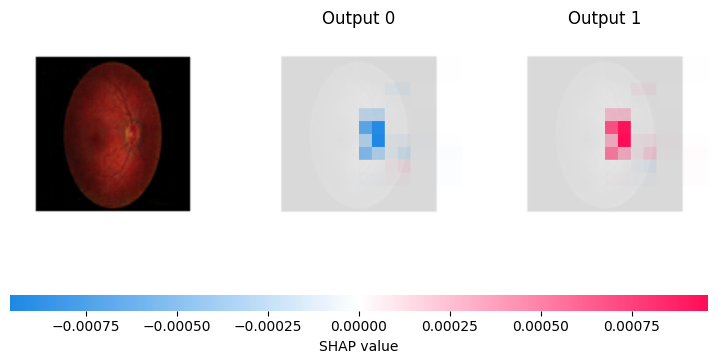

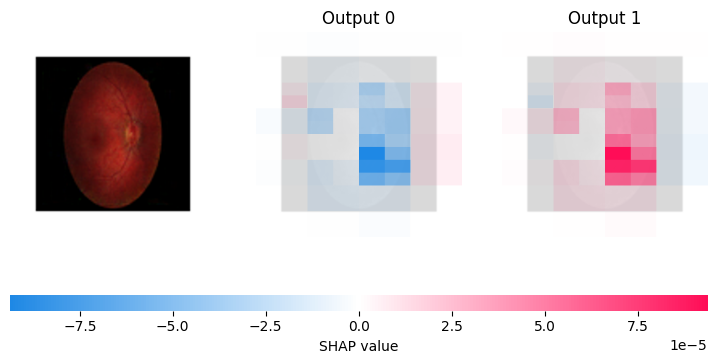

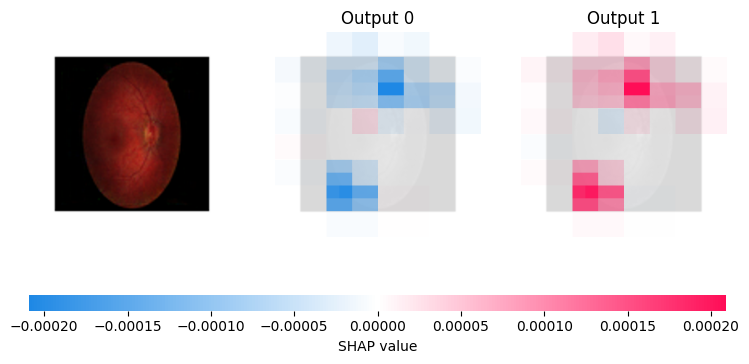

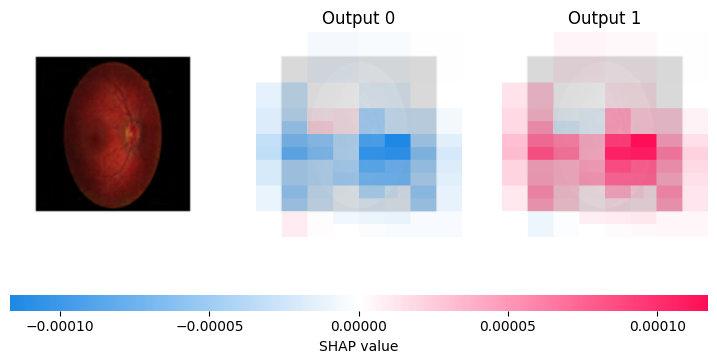

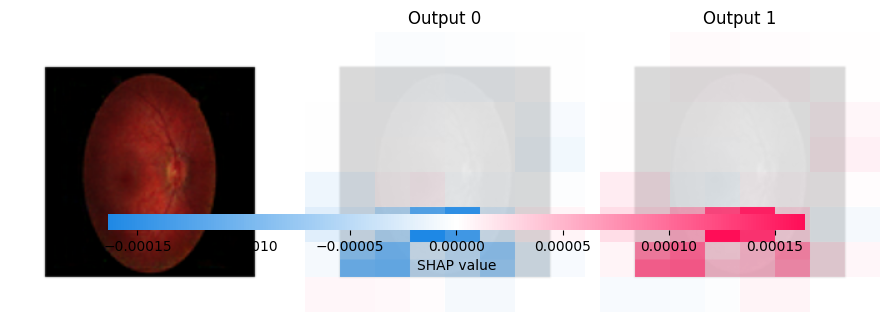

In [22]:
import torch
import shap
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.datasets import ImageFolder

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset transformations
def get_transform(input_size):
    return Compose([
        Resize(input_size),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Load dataset
dataset_path = "/kaggle/input/dataset/final_dataset"  # Replace with your dataset path
dataset = ImageFolder(root=dataset_path)

# Select a random image from the dataset
random_index = torch.randint(0, len(dataset), (1,)).item()
image_path, label = dataset.samples[random_index]
image = Image.open(image_path).convert("RGB")
true_class = dataset.classes[label]


# SHAP explanation
def explain_with_shap(model, image, input_size):
    # Preprocess the image
    transform = get_transform(input_size)
    transformed_image = transform(image).unsqueeze(0).to(device)

    # Convert image to numpy format for SHAP
    image_np = np.array(image.resize(input_size)).astype(np.float32) / 255.0

    # Wrap the model for SHAP
    def model_forward(batch):
        batch = torch.tensor(batch.transpose((0, 3, 1, 2)), dtype=torch.float32).to(device)
        outputs = model(batch)
        probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy()
        return probabilities

    # Create SHAP explainer
    masker = shap.maskers.Image("blur(128,128)", image_np.shape)
    explainer = shap.Explainer(model_forward, masker)

    # Explain the image
    shap_values = explainer(np.expand_dims(image_np, axis=0))
    return shap_values

# Visualize SHAP explanations


for i, (model_name, model) in enumerate(models_dict.items()):
    try:
        input_size = (224, 224)  # Default input size for models
        shap_values = explain_with_shap(model, image, input_size)

        # Plot the SHAP explanation
        shap.image_plot(shap_values, show=False)

        # Display the SHAP explanation for the model
        shap_image = shap_values[0].values[..., 1]  # Class 1 (positive explanation)3

        axes[i + 1, 1].imshow(shap_image, cmap="coolwarm")
        axes[i + 1, 1].set_title(f"SHAP Overlay - {model_name}")
        axes[i + 1, 1].axis("off")
    except Exception as e:
        print(f"SHAP explanation failed for {model_name}: {e}")

plt.tight_layout()
plt.show()


Individual Model Predictions:
ResNet18: Predicted - Normal with Confidence - 1.00
EfficientNet: Predicted - Normal with Confidence - 1.00
DenseNet121: Predicted - Normal with Confidence - 1.00
Xception: Predicted - Normal with Confidence - 0.95
MobileNetV2: Predicted - Normal with Confidence - 1.00

Ensemble Results:
Averaging: Predicted - Normal with Confidence - 0.99
Weighted Averaging: Predicted - Normal with Confidence - 0.99
Majority Voting: Predicted - Normal


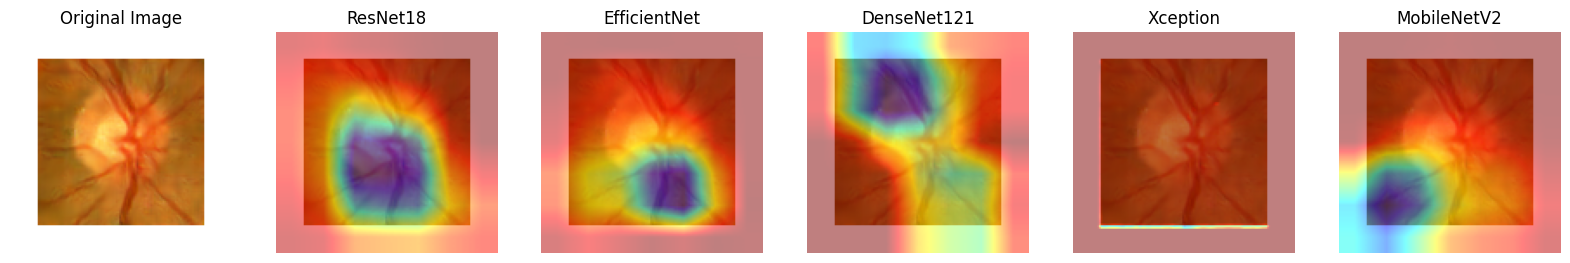

In [5]:


# Load models
for model_name, model in models_dict.items():
    if hasattr(model, 'fc'):
        model.fc = torch.nn.Linear(model.fc.in_features, 2)
    elif hasattr(model, 'classifier'):
        if isinstance(model.classifier, torch.nn.Sequential):
            model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, 2)
        else:
            model.classifier = torch.nn.Linear(model.classifier.in_features, 2)
    elif hasattr(model, 'head'):
        model.head = torch.nn.Linear(model.head.in_features, 2)

    model.load_state_dict(torch.load(model_paths[model_name], map_location=device, weights_only=True))
    model.to(device)
    model.eval()

# Dataset transformations
def get_transform(input_size):
    return Compose([
        Resize(input_size),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Dynamic target layer selection
def get_target_layer(model, model_name):
    """
    Dynamically get the target convolutional layer for Grad-CAM.
    """
    if model_name == "ResNet18":
        return model.layer4[-1]  # Last block of ResNet18's layer4
    elif model_name == "EfficientNet":
        return model.features[-1]  # Last convolutional layer of EfficientNet
    elif model_name == "DenseNet121":
        return model.features[-1]  # Last convolutional layer of DenseNet
    elif model_name == "Xception":
        # Dynamically find the last convolutional layer for Xception
        for layer in reversed(list(model.children())):
            if isinstance(layer, torch.nn.Conv2d):
                return layer
        raise ValueError(f"No convolutional layer found in Xception model.")
    elif model_name == "MobileNetV2":
        return model.features[-1]  # Last convolutional layer of MobileNetV2
    else:
        raise ValueError(f"Unsupported model for Grad-CAM: {model_name}")

# Grad-CAM utility functions
def generate_gradcam(model, transformed_image, target_layer):
    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    # Perform forward pass
    outputs = model(transformed_image)
    class_idx = torch.argmax(outputs, dim=1).item()

    # Perform backward pass
    model.zero_grad()
    outputs[0, class_idx].backward()

    # Extract activations and gradients
    grad = gradients[0].cpu().data.numpy()
    act = activations[0].cpu().data.numpy()

    # Calculate weights using global average pooling
    weights = np.mean(grad, axis=(2, 3))
    cam = np.zeros(act.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights[0]):
        cam += w * act[0, i]

    cam = np.maximum(cam, 0)  # ReLU
    cam -= np.min(cam)  # Normalize to [0, 1]
    cam /= np.max(cam) if np.max(cam) != 0 else 1
    cam = (cam * 255).astype(np.uint8)  # Scale to [0, 255]

    # Cleanup hooks
    handle_forward.remove()
    handle_backward.remove()

    return cam

   

def overlay_gradcam(image, cam, alpha=0.5):
    cam_resized = cv2.resize(cam, image.size, interpolation=cv2.INTER_LINEAR)
    cam_colored = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
    image_np = np.array(image).astype(np.float32) / 255.0
    cam_colored = cam_colored.astype(np.float32) / 255.0
    overlay = (1 - alpha) * image_np + alpha * cam_colored
    overlay = np.clip(overlay, 0, 1)
    return (overlay * 255).astype(np.uint8)


# Ensemble variables
class_votes = {}
prob_sum = torch.zeros(2).to(device)  # 2 classes
weighted_prob_sum = torch.zeros(2).to(device)

# Load dataset
dataset_path = "/kaggle/input/dataset/final_dataset"
dataset = ImageFolder(root=dataset_path)

# Pick a random image
random_index = torch.randint(0, len(dataset), (1,)).item()
image_path, label = dataset.samples[random_index]
image = Image.open(image_path).convert("RGB")
true_class = dataset.classes[label]

# Grad-CAM application and predictions
results = []
gradcam_images = []

for model_name, model in models_dict.items():
    input_size = model_input_sizes[model_name]
    transform = get_transform(input_size)
    transformed_image = transform(image).unsqueeze(0).to(device)

    # Get target layer dynamically
    target_layer = get_target_layer(model, model_name)

    cam = generate_gradcam(model, transformed_image, target_layer)
    gradcam_overlay = overlay_gradcam(image, cam)

    # Prediction
    with torch.no_grad():
        outputs = model(transformed_image)
        probs = torch.softmax(outputs, dim=1)
        confidence, predicted_class_idx = torch.max(probs, dim=1)
        predicted_class = dataset.classes[predicted_class_idx.item()]

    # Ensemble
    class_votes[predicted_class] = class_votes.get(predicted_class, 0) + 1
    prob_sum += probs.squeeze()
    weighted_prob_sum += model_weights[model_name] * probs.squeeze()

    # Store Grad-CAM
    gradcam_images.append((model_name, gradcam_overlay))
    results.append(f"{model_name}: Predicted - {predicted_class} with Confidence - {confidence.item():.2f}")

# Ensemble predictions
avg_probs = prob_sum / len(models_dict)
weighted_probs = weighted_prob_sum / sum(model_weights.values())
avg_pred_class = dataset.classes[torch.argmax(avg_probs).item()]
weighted_pred_class = dataset.classes[torch.argmax(weighted_probs).item()]
majority_class = max(class_votes, key=class_votes.get)

# Display individual predictions
print("Individual Model Predictions:")
for result in results:
    print(result)

# Display ensemble predictions
print("\nEnsemble Results:")
print(f"Averaging: Predicted - {avg_pred_class} with Confidence - {avg_probs.max().item():.2f}")
print(f"Weighted Averaging: Predicted - {weighted_pred_class} with Confidence - {weighted_probs.max().item():.2f}")
print(f"Majority Voting: Predicted - {majority_class}")

# Visualize Grad-CAM results
fig, axes = plt.subplots(1, len(gradcam_images) + 1, figsize=(20, 6))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

for i, (model_name, gradcam_overlay) in enumerate(gradcam_images):
    axes[i + 1].imshow(gradcam_overlay)
    axes[i + 1].set_title(model_name)
    axes[i + 1].axis("off")

plt.show()


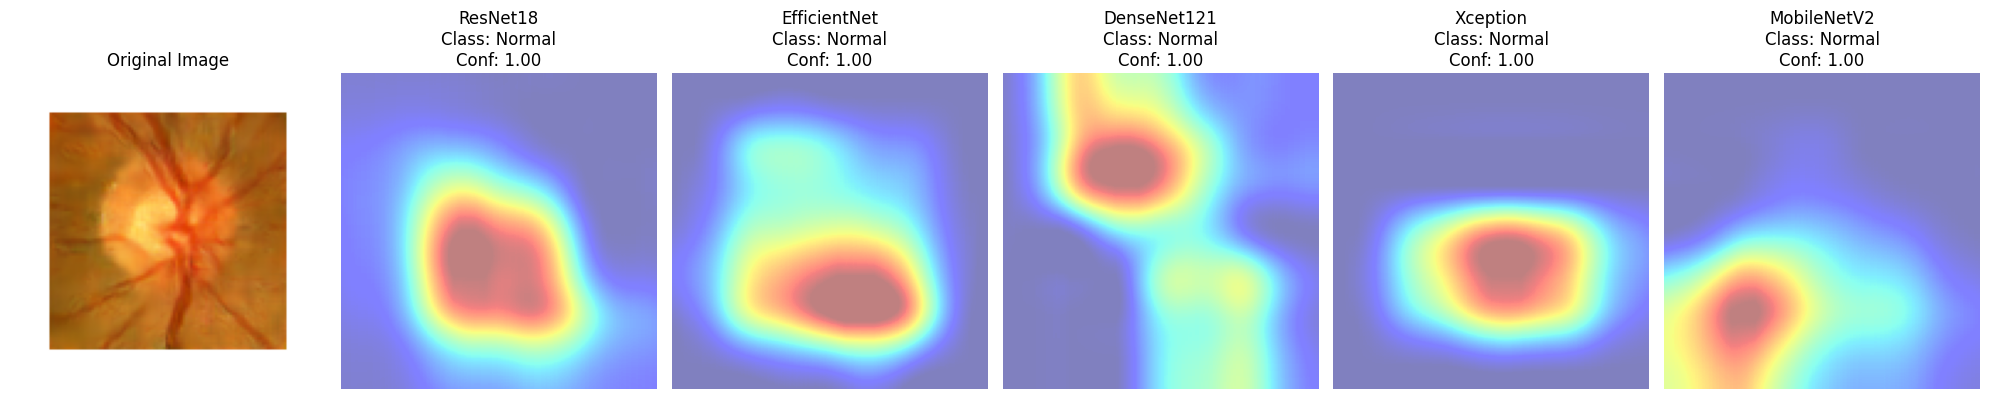

NameError: name 'pd' is not defined

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Grad-CAM utility function
def generate_gradcam(model, transformed_image, target_layer):
    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    outputs = model(transformed_image)
    class_idx = torch.argmax(outputs, dim=1).item()

    # Backward pass
    model.zero_grad()
    outputs[0, class_idx].backward()

    # Generate Grad-CAM heatmap
    grad = gradients[0].cpu().data.numpy()
    act = activations[0].cpu().data.numpy()

    weights = np.mean(grad, axis=(2, 3))
    cam = np.zeros(act.shape[2:], dtype=np.float32)
    for i, w in enumerate(weights[0]):
        cam += w * act[0, i]

    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = Image.fromarray((cam * 255).astype(np.uint8)).resize((224, 224), Image.LANCZOS)

    handle_forward.remove()
    handle_backward.remove()
    return cam

# Target convolutional layer detection
def get_target_layer(model):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            last_conv = module
    return last_conv

# Visualization function
def visualize_results(image, models_dict, results, gradcam_images):
    fig, axes = plt.subplots(1, len(models_dict) + 1, figsize=(20, 6))

    # Display the original image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Display Grad-CAM results
    for i, (model_name, result) in enumerate(zip(models_dict.keys(), results)):
        if gradcam_images[i] is not None:  # Only display Grad-CAM if available
            axes[i + 1].imshow(gradcam_images[i], cmap="jet", alpha=0.5)
        else:
            axes[i + 1].text(0.5, 0.5, "Grad-CAM Not Available",
                             horizontalalignment='center',
                             verticalalignment='center',
                             fontsize=10, color="red", transform=axes[i + 1].transAxes)
        axes[i + 1].set_title(
            f"{model_name}\nClass: {result['Predicted Class']}\nConf: {result['Confidence Score']:.2f}"
        )
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

# Grad-CAM application and visualization
results = []
gradcam_images = []

for model_name, model in models_dict.items():
    try:
        # Prediction
        with torch.no_grad():
            outputs = model(transformed_image)
            probs = torch.softmax(outputs, dim=1)
            confidence, predicted_class_idx = torch.max(probs, dim=1)
            predicted_class = dataset.classes[predicted_class_idx.item()]

        # Grad-CAM
        target_layer = get_target_layer(model)
        gradcam = generate_gradcam(model, transformed_image, target_layer)
        gradcam_images.append(gradcam)

        # Append Results
        results.append({
            "Model": model_name,
            "True Class": true_class,
            "Predicted Class": predicted_class,
            "Confidence Score": confidence.item(),
        })
    except Exception as e:
        print(f"Grad-CAM failed for {model_name}: {e}")
        gradcam_images.append(None)

# Visualize Results
visualize_results(image, models_dict, results, gradcam_images)

# Display Results Table
results_df = pd.DataFrame(results)
print(results_df)
